# DecayChain

In [1]:
import matplotlib.pyplot as plt
from graphviz import Digraph
import math

from data.symbols import atomic_symbols, atomic_numbers
from data.library import lib
from data.half_times import half_times

In [82]:
# the activity R at time t can be calculated using the equation: $R = R_0 ^{-\lambda t}$
# the number of radiactive nuclei remaining after time t is: $N = N_0 e^{-\lambda t}$


class DecayChain:
    def __init__(self):
        """
        Initialize the DecayChain class with nuclide data.

        :param nuclide_data: List of tuples containing nuclide information.
        """
        self.nuclide_data = lib  # Store the nuclide data
        self.decay_chain = []  # To store the decay chain
        self.final_amounts = {}  # To store final amounts of each nuclide

    def get_nuclide_data(self, current_nuclide):
        """
        Access the data for a specific nuclide based on mass number and atomic symbol.

        :param starting_nuclide: a tuple consisting of (mass_number, atomic_symbol)
        :return: the corresponding list or None if not found.
        """
        mass_number, atomic_number = current_nuclide
        for nuclide in self.nuclide_data:
            try: 
                if int(nuclide[0])==atomic_number and int(nuclide[2])==mass_number:
                    return nuclide
            except Exception as e:
                pass

        raise ValueError(f"Nuclide not found; input: {current_nuclide}")

    def atomicsymbol_2_atomicnumber(self, atomic_symbol):
        """
        :param atomic_symbol: string containing atomic symbol
        :return: atomic_number: integer representing the atomic number of the given symbol
        """
        return atomic_numbers[atomic_symbol]

    def atomicnumber_2_atomicsymbol(self, atomic_number):
        """
        :param atomic_number: integer representing the atomic number
        :return: atmoic_symbol: string representing the atomic symbol of the given number
        """
        return atomic_symbols[atomic_number]

    def find_decay_chain(self, starting_nuclide):
        """
        Find the decay chain starting from a given nuclide.

        :param starting_nuclide: A tuple containing: (mass_number, atomic_number) or (mass_number, atomic_symbol)
        :return: A list representing the decay chain.
        """
        # Check if the second element is an integer (atomic number) or convert from atomic symbol
        if isinstance(starting_nuclide[1], int):
            current_nuclide = (int(starting_nuclide[0]), starting_nuclide[1])
        else:
            current_nuclide = (int(starting_nuclide[0]), self.atomicsymbol_2_atomicnumber(starting_nuclide[1]))

        dc = [current_nuclide]

        while True:
            nuclide_data = self.get_nuclide_data(current_nuclide)

            # Check for decay modes
            print(nuclide_data[6])
            if 'a' in nuclide_data[6]:
                current_nuclide = (current_nuclide[0] - 4, current_nuclide[1] - 2)  # Alpha decay
                dc.append(('a', current_nuclide))
            elif 'b' in nuclide_data[6]:
                current_nuclide = (current_nuclide[0], current_nuclide[1] + 1)  # Beta decay
                dc.append(('b', current_nuclide))
            elif ('g' in nuclide_data[6] and 'a' not in nuclide_data[6]) or ('g' in nuclide_data[6] and 'b' not in nuclide_data[6]):
                dc.append(('g', 'g'))
                break
            else:
                break

        self.decay_chain = dc
        return dc  # Return the decay chain for further use

    def chain_chart(self):
        """
        Make a flow chart of the decay chain starting from a given nuclide,
        or using an already created chain list (outputted by find_decay_chain).

        :return: Show and save figure (PNG).
        """
        cmap = {
            'a': 'yellow',
            'b': 'blue'
        }

        if not self.decay_chain:
            raise ValueError("You must first run the find_decay_chain function to create a decay chain.")

        dc = self.decay_chain

        # Create directed graph
        dot = Digraph(f'./charts/{dc[0]}_decay_chain', format='png')
        dot.attr(rankdir='TB', size='12', dpi='600')
        dot.attr('node', shape='box', style='rounded, filled', color='lightblue', fontname='Arial', fontsize='12')

        for i in range(len(dc)):
            if isinstance(dc[i], tuple):
                if isinstance(dc[i][1], str):
                    print(f'Final gamma: {dc[i]}')
                    dot.node(f'gamma_{i}', 'Gamma Radiation', color='lightgrey')

                    if len(dc)==2:
                        prev_mass_number = dc[i-1][0]
                        prev_atomic_number = dc[i-1][1]
                        prev_id = f'{prev_mass_number}_{prev_atomic_number}'
                        dot.edge(prev_id, f'gamma_{i}', label='g')
                    else:
                        prev_mass_number = dc[i - 1][1][0]
                        prev_atomic_number = dc[i - 1][1][1]
                        prev_id = f'{prev_mass_number}_{prev_atomic_number}'
                        dot.edge(prev_id, f'gamma_{i}', label='g')
                        
                elif isinstance(dc[i][0], str):
                    print(f'Intermediate: {dc[i]}')
                    radiation = dc[i][0]
                    mass_number, atomic_number = dc[i][1]
                    node_id = f'{mass_number}_{atomic_number}'
                    dot.node(node_id, f"{self.atomicnumber_2_atomicsymbol(atomic_number)}-{mass_number}", color=cmap[radiation])

                    prev_mass_number, prev_atomic_number = dc[i - 1][1]
                    prev_id = f'{prev_mass_number}_{prev_atomic_number}'
                    dot.edge(prev_id, node_id, label=radiation)
                    
                
                    
                else: # initial nuclide
                    print(f'Initial: {dc[i]}')
                    mass_number, atomic_number = dc[i]
                    node_id = f'{mass_number}_{atomic_number}'
                    dot.node(node_id, f"{self.atomicnumber_2_atomicsymbol(atomic_number)}-{mass_number}")
                

        # Add a legend
        with dot.subgraph(name='legend') as legend:
            legend.attr(label='Legend', color='black', style='dashed')
            legend.node('a', 'Alpha Decay', color=cmap['a'])
            legend.node('b', 'Beta Decay', color=cmap['b'])

        # Save diagram
        dot.render(f"../{dc[0]}_decay_chain", cleanup=True)

        # Show diagram
        dot.view()  # This will open the generated PNG file

    def half_time(self):
        # TODO: rewrite this for new database
        """
        Compute the total decay time for a given decay chain.

        This function calculates the total decay time of a decay chain
        by summing the half-lives of all the nuclides involved in the chain.

        :return: Total decay time for the chain.
        """
        dc = self.decay_chain
        total_decay_time = 0

        for item in dc:
            # TODO: substitute this for the read class functions
            if isinstance(item, tuple) and len(item) == 2:
                nuc = ''
                if isinstance(item[1], str):
                    break
                elif isinstance(item[0], str):
                    decay_mode, (mass_number, atomic_number) = item
                    atomic_symbol = self.atomicnumber_2_atomicsymbol(atomic_number)
                    nuc = f'{atomic_symbol.lower()}{mass_number}'
                else:
                    mass_number, atomic_number = item
                    atomic_symbol = self.atomicnumber_2_atomicsymbol(atomic_number)
                    nuc = f'{atomic_symbol.lower()}{mass_number}'
                try:
                    total_decay_time += half_times[nuc]
                except KeyError as e:
                    print(f"Decay constant not found for {nuc}: {e}")

        return total_decay_time

    def simulate_decay(self, initial_amount, time_period=None):
        """
        Calculate the percentages of each transited element left in the sample after decay.

        :param initial_amount: The initial amount of the starting nuclide.
        :param time_period: The total time over which to simulate decay.
                            If not provided, it defaults to the sum of half-times of the decay chain.
        :return: A dictionary with percentages of each element remaining.
        """
        if time_period is None:
            try:
                time_period = self.half_time()  # Use computed decay time if not provided
            except Exception as e:
                raise ValueError("Provide a time_period or run the compute_decay_time function first.")

        remaining_amounts = {}

        for item in self.decay_chain:
            if isinstance(item, tuple) and len(item) == 2:
                nuc = ''
                if isinstance(item[1], str):
                    break
                elif isinstance(item[0], str):
                    decay_mode, (mass_number, atomic_number) = item
                    atomic_symbol = self.atomicnumber_2_atomicsymbol(atomic_number)
                    nuc = f'{atomic_symbol.lower()}{mass_number}'
                else:
                    mass_number, atomic_number = item
                    atomic_symbol = self.atomicnumber_2_atomicsymbol(atomic_number)
                    nuc = f'{atomic_symbol.lower()}{mass_number}'

                try:
                    decay_constant = math.log(2) / half_times[nuc]

                    # Calculate remaining amount using exponential decay formula
                    remaining_amount = initial_amount * math.exp(-decay_constant * time_period)

                    # Store result as a percentage of the initial amount
                    remaining_percent = (remaining_amount / initial_amount) * 100
                    remaining_amounts[nuc] = remaining_percent

                    # Update initial_amount for subsequent nuclides in chain
                    initial_amount = remaining_amount  # Update for next nuclide's calculation

                except KeyError as e:
                    print(f"Decay constant not found for {nuc}: {e}")
                except Exception as e:
                    print(f"Error simulating decay for {nuc}: {e}")

        return remaining_amounts

    def plot_decay_results(self, remaining_amounts):
        """
        Plot a pie chart showing the percentages of each transited element remaining after decay.

        :param remaining_amounts: the output of the simulate_decay function
        """
        nuclide_names = remaining_amounts.keys()
        percentages = remaining_amounts.values()

        plt.figure(figsize=(10, 7))
        plt.pie(percentages, labels=nuclide_names)

        plt.show()
        plt.savefig("../remaining_amounts_distribution.png", dpi=600)



# Example usage:
# Assuming you have loaded your nuclide data into a variable called `nuclide_data`
# decay_chain = DecayChain(nuclide_data)
# decay_chain.find_decay_chain('Starting_Nuclide_Symbol')
# decay_chain.simulate_decay(initial_amount=1000, time_period=5000)
# decay_chain.plot_decay_results()


In [83]:
decay_chain = DecayChain()

In [103]:
decay_chain.get_nuclide_data((142, 54))

('54', 'Xe', '142', '141.9297111', '', '131.2936', 'g,m,a')

In [104]:
decay_chain.find_decay_chain((142, 54))

g,m,a
g,h


[(142, 54), ('a', (138, 52)), ('g', 'g')]

In [105]:
decay_chain.chain_chart()

Initial: (142, 54)
Intermediate: ('a', (138, 52))


TypeError: cannot unpack non-iterable int object

In [106]:
decay_chain.half_time()

2.63

In [107]:
decay_chain.simulate_decay(100)

{'xe142': 22.716124325451776, 'te138': 27.195287287278674}

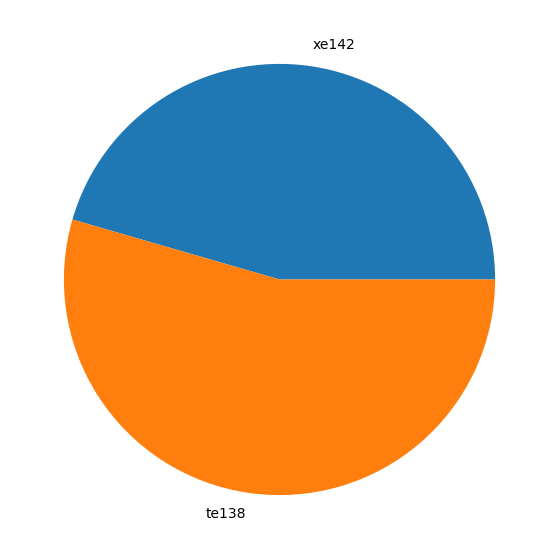

<Figure size 640x480 with 0 Axes>

In [108]:
decay_chain.plot_decay_results(decay_chain.simulate_decay(100))